# Мобильная игра - Анализ рекламных источников

## Материалы:
1. [Презентация](https://drive.google.com/file/d/1Mxy8fKxJmZ5bBIbd2V3KaG-05sw52n9y/view?usp=sharing)
2. [Дашборд](https://public.tableau.com/profile/maria7891#!/vizhome/games_16087287169970/-?publish=yes)

Команда мобильной игры «Космические братья» планирует монетизировать сервис. Необходимо проанализировать поведение пользователей, пришедших в игру из различных источников. На выходе требуется предоставить оценку эффективности каждого источника с точки зрения потенциальной прибыли от показа реклама внутри игры.

**Логика игры**

Пользователи мобильной игры «Космические братья» строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики. Завершение первого уровня требует от игрока выполнения одного из двух условий:
- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

Какую бы сратегию пользователь не выбрал, в процессе игры он возводит объекты трёх типов:
- сборочный цех
- космопорт
- исследовательский центр

Предполагается, что показ рекламы будет происходить на экране с выбором типа объекта для постройки.

**В нашем распоряжении следующие данные:**

**game_actions.csv** - данные по игре пользователей на первом уровне:
- `event_datetime` — время события
- `event` — одно из трёх событий:
    - `building` — объект построен
    - `finished_stage_1` — первый уровень завершён
    - `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    - `assembly_shop` — сборочный цех
    - `spaceport` — космопорт
    - `research_center` — исследовательский центр
- `user_id` — идентификатор пользователя
- `project_type` — тип реализованного проекта

**ad_cost.csv** - информация о рекламных активностях:
- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

**user_source.csv** - источники пользователей:
- `user_id` - идентификатор пользователя
- `source` - источник, из которого пришёл пользователь, установивший приложение

## План работы <a id="plan"></a> 
1. [Обзор данных](#st1)
1. [Предобработка данных](#st2)
1. [Исследовательский анализ данных (EDA)](#st3)
    - 3.1. [Количество пользователей и событий за период (всего и по источнику)](#st3_1)
    - 3.2. [Анализ игровых стратегий пользователей (боевая/строительная - всего и по источнику):](#st3_2)
        - Количество игроков, завершивших уровень 
        - Соотношение стратегий прохождения уровня
        - Время прохождения уровня
        - Количество построенных объектов
    - 3.3. [Расчёт метрик (по источнику)](#st3_3):
        - Частота возвращений пользователя (DAU/WAU/Sticky factor)
        - Коэффициент удержания пользователей (Retention Rate)
        - LTV - среднее количество построенных объектов на пользователя
        - Стоимость привлечения пользователя (CAC)
1. [Проверка гипотез](#st4)
    - 4.1. [Время завершения уровня различается в зависимости способа прохождения (через реализацию проекта/через победу над первым врагом)](#st4_1)
    - 4.2. [Количество построенных объектов не зависит от источника трафика](#st4_2)
    - 4.3. [Количество построенных объектов не зависит от способа прохождения уровня](#st4_3)
1. [Выводы и рекомендации](#st5)

## [1. Обзор данных](#plan) <a id="st1"></a> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats
from IPython.core.display import display
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

Загрузим данные:

In [2]:
game_actions = pd.read_csv('game_actions.csv')
ad_costs = pd.read_csv('ad_costs.csv')
user_source = pd.read_csv('user_source.csv')

In [3]:
def df_info(df):
    """
    Функция выводит информацию по датафрейму (head(), info(), describe(), пропущенные значения и дубликаты)
    Входные параметры:
        `df` - датафрейм
    """    
    display(df.head())
    print(df.info())
    display(df.describe())
    print('Пропущенные значения:')
    print(df.isna().sum())
    print('\nДубликаты:', df.duplicated().sum()) 

Рассмотрим данные о поведении пользователей на первом уровне:

In [4]:
df_info(game_actions)

event_datetime     event  building_type  \
0  2020-05-04 00:00:01  building  assembly_shop   
1  2020-05-04 00:00:03  building  assembly_shop   
2  2020-05-04 00:00:16  building  assembly_shop   
3  2020-05-04 00:00:16  building  assembly_shop   
4  2020-05-04 00:00:35  building  assembly_shop   

                                user_id project_type  
0  55e92310-cb8e-4754-b622-597e124b03de          NaN  
1  c07b1c10-f477-44dc-81dc-ec82254b1347          NaN  
2  6edd42cc-e753-4ff6-a947-2107cd560710          NaN  
3  92c69003-d60a-444a-827f-8cc51bf6bf4c          NaN  
4  cdc6bb92-0ccb-4490-9866-ef142f09139d          NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB
None


event_datetime     event building_type  \
count                135640    135640        127957   
unique               128790         3             3   
top     2020-05-09 12:35:56  building     spaceport   
freq                      4    127957         59325   

                                     user_id                project_type  
count                                 135640                        1866  
unique                                 13576                           1  
top     ff841992-d93b-462e-bc6e-18c24a514f36  satellite_orbital_assembly  
freq                                      22                        1866

Пропущенные значения:
event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

Дубликаты: 1


**Выводы:**
- в нашем распоряжении 135640 событий от 13576 уникальных пользователей
- количество уникальных значений `building_type` и `event` совпадают с ожиданиями (по 3)
- `building_type` пропущего 7683 раза, что допустимо
- в поле с типом реализованного проекта `project_type` встречается только одно значение - "satellite_orbital_assembly" - и только 1866 раз, в остальных 133774 строках значение пропущено
- один дубль

Необходимо:
- изменить тип поля `event_datetime` на datetime
- удалить дубль

Изучим информацию о рекламных активностях:

In [5]:
df_info(ad_costs)
print('\nИсточники:', ad_costs['source'].unique())

source         day        cost
0  facebook_ads  2020-05-03  935.882786
1  facebook_ads  2020-05-04  548.354480
2  facebook_ads  2020-05-05  260.185754
3  facebook_ads  2020-05-06  177.982200
4  facebook_ads  2020-05-07  111.766796

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes
None


cost
count   28.000000
mean   271.556321
std    286.867650
min     23.314669
25%     66.747365
50%    160.056443
75%    349.034473
max    969.139394

Пропущенные значения:
source    0
day       0
cost      0
dtype: int64

Дубликаты: 0

Источники: ['facebook_ads' 'instagram_new_adverts' 'yandex_direct'
 'youtube_channel_reklama']


**Выводы:**
- всего в базе 28 записей
- типов рекламных источников: 4
- пропущенных значений и дубликатов нет

Необходимо:
- изменить тип поля `day` на datetime
- переименовать поле `day` в `date`

Изучим информацию об источниках, из которых пришли игроки:

In [6]:
df_info(user_source)
print('\n', user_source['source'].unique())

user_id                   source
0  0001f83c-c6ac-4621-b7f0-8a28b283ac30             facebook_ads
1  00151b4f-ba38-44a8-a650-d7cf130a0105            yandex_direct
2  001aaea6-3d14-43f1-8ca8-7f48820f17aa  youtube_channel_reklama
3  001d39dc-366c-4021-9604-6a3b9ff01e25    instagram_new_adverts
4  002f508f-67b6-479f-814b-b05f00d4e995             facebook_ads

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB
None


user_id         source
count                                  13576          13576
unique                                 13576              4
top     e77a337a-6920-4688-8ea9-7fcd61302097  yandex_direct
freq                                       1           4817

Пропущенные значения:
user_id    0
source     0
dtype: int64

Дубликаты: 0

 ['facebook_ads' 'yandex_direct' 'youtube_channel_reklama'
 'instagram_new_adverts']


**Выводы:**
- количество уникальных пользователей соответсвует логам
- рекламные источники совпадают с данными о затратах
- пропусков и дублей нет

## [2. Предобработка данных](#plan) <a id="st2"></a> 

In [7]:
def to_dttime(df, param, frmt):
    """
    Функция заменяет тип поля на datetime по заданному формату frmt.
    Входные параметры:
        `df` - датафрейм
    """
    try:
        df[param] = pd.to_datetime(df[param], format=frmt)
    except:
        print('Проверьте корректность данных в поле', param)

In [8]:
# Заменим тип данных на datetime там, где это нужно:
to_dttime(game_actions, 'event_datetime', '%Y-%m-%d %H:%M:%S')
to_dttime(ad_costs, 'day', '%Y-%m-%d')

In [9]:
# Переименуем поле ad_costs['day'] в ad_costs['date']:
ad_costs.rename(columns = {'day':'date'}, inplace = True)

In [10]:
# Удалим дубль из `game_actions`:
game_actions = game_actions.drop_duplicates()

## [3. Исследовательский анализ данных (EDA)](#plan) <a id="st3"></a> 

In [11]:
# Добавим в `game_actions` необходимые для анализа поля:
game_actions['date'] = game_actions['event_datetime'].dt.date
game_actions['month'] = game_actions['event_datetime'].dt.month
game_actions['week'] = game_actions['event_datetime'].dt.week
game_actions['weekday'] = game_actions['event_datetime'].dt.day_name()
game_actions['hour'] = game_actions['event_datetime'].dt.hour

# Добавим в `game_actions` информацию об источнике, из которого пришёл пользователь:
game_actions = game_actions.merge(user_source, how='left', on='user_id')

### [3.1. Количество пользователей и событий за период (всего и по источнику)](#plan) <a id="st3_1"></a> 

In [12]:
def nusers_period(df, period, period_name):  
    """
    Функция подсчитывает количество уникальных пользователей и количество событий за период, выводит графики;
    строит графики распределений, а также выводит описание .describe() группировки.
    Входные параметры:
        `df` - датафрейм с информацией о событиях в игре
        `period` - список полей для группировки по периоду
        `period_name` - название периода в винительном падеже для заголовков.
    """
    nusers = (df.groupby(period)
                  .agg(
                      user_count = ('user_id','nunique'),
                      event_count = ('user_id','count'))
             )
    nusers['events_per_user'] = nusers['event_count'] /  nusers['user_count']
    nusers = nusers.sort_values(by=period)
    nusers[['user_count', 'event_count']].plot(figsize=(15,5), kind='bar', grid=True,
                                               title='Количество пользователей/событий в '+ period_name)
    plt.xlabel('')
    plt.ylabel('количество пользователей/событий')
    plt.legend(['пользователи','события'])
    plt.show()

    plt.figure(figsize=(10,5))
    sns.distplot(nusers['user_count'], bins=10, label='пользователи')
    sns.distplot(nusers['event_count'], bins=10, label='события')
    plt.title('Распределение количества пользователей/событий в ' + period_name)
    plt.xlabel('')
    plt.legend()
    plt.show() 
    
    display(nusers.describe())

Посмотрим, как распределено количество уникальных пользователей и количество событий в день:

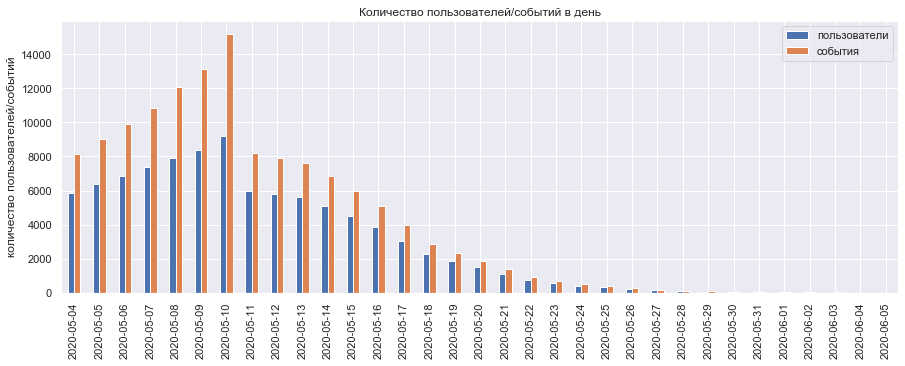

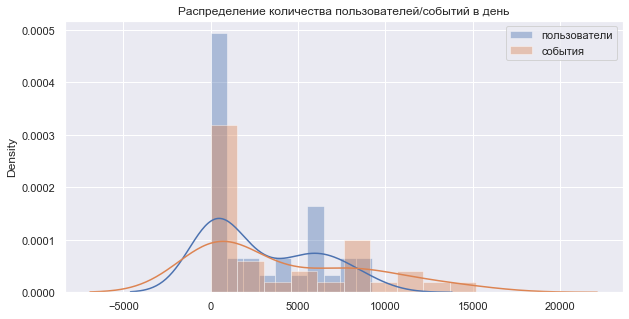

user_count   event_count  events_per_user
count    33.000000     33.000000        33.000000
mean   2884.878788   4110.272727         1.333484
std    3083.784493   4639.714311         0.106301
min       4.000000      5.000000         1.215385
25%      91.000000    118.000000         1.252160
50%    1480.000000   1837.000000         1.296703
75%    5776.000000   7918.000000         1.370845
max    9219.000000  15207.000000         1.649528

In [13]:
nusers_period(game_actions, ['date'], 'день')

- Среднее количество пользователей в день: 2885 (минимум - 4, максимум - 9219). Распределение смещено вправо. Отчётливо видно границу, до которой количество пользователей и событий нарастает, а после снижается - это первая неделя игры.
- Среднее количество событий в день: 4110 (минимум - 5, максимум - 15207). Распределение так же смещено вправо.
- Среднее количество событий на пользователя: 1.33 (минимум - 1.22, максимум - 1.65) - не сильно колеблется с течением времени.

В неделю:

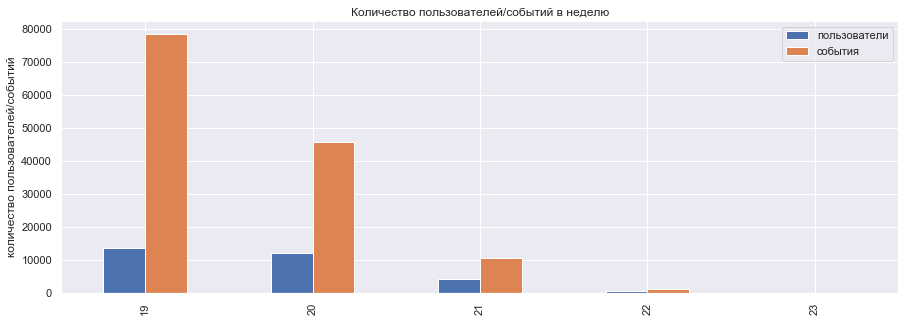

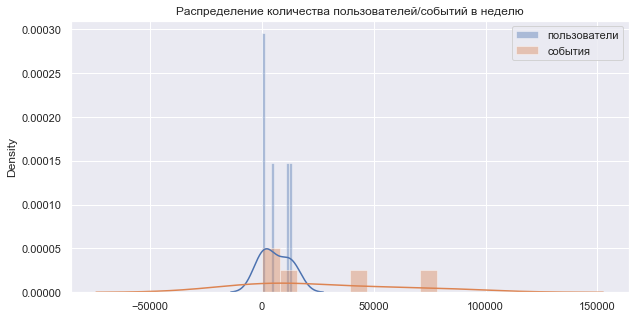

user_count   event_count  events_per_user
count      5.00000      5.000000         5.000000
mean    6120.00000  27127.800000         3.230699
std     6387.00454  34115.225218         1.578515
min       29.00000     61.000000         2.099808
25%      521.00000   1094.000000         2.103448
50%     4353.00000  10517.000000         2.416035
75%    12121.00000  45563.000000         3.759013
max    13576.00000  78404.000000         5.775192

In [14]:
nusers_period(game_actions, ['week'], 'неделю')

- Отчётливо заметен спад посещений с каждой последующей неделей.
- Количество событий на пользователя в первую неделю значительно выше, чем во вторую и третью - наибольшую активность пользователи в целом проявляют именно в первую неделю игры.

По времени суток:

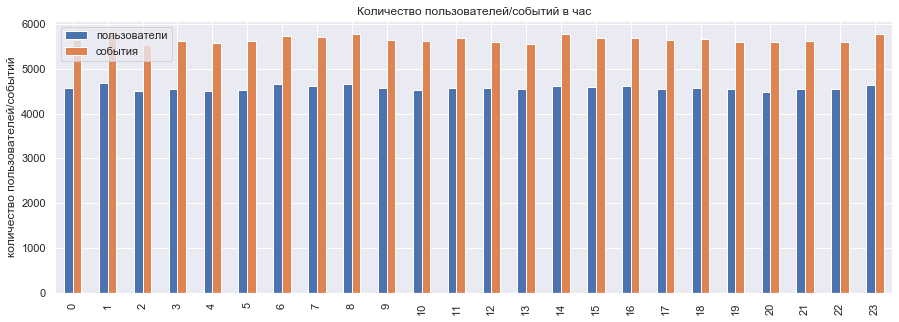

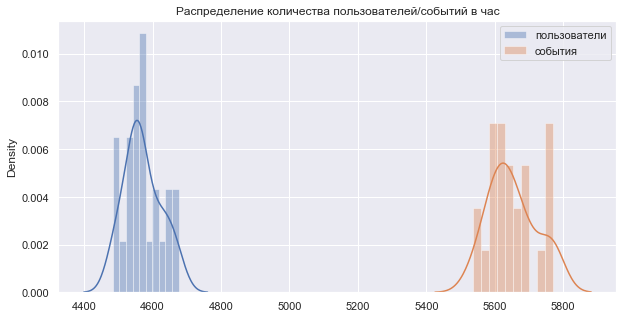

user_count  event_count  events_per_user
count    24.000000    24.000000        24.000000
mean   4570.916667  5651.625000         1.236443
std      53.322576    69.613725         0.007238
min    4484.000000  5536.000000         1.218393
25%    4539.500000  5596.250000         1.232755
50%    4562.000000  5636.500000         1.235901
75%    4613.250000  5686.000000         1.241830
max    4676.000000  5771.000000         1.250650

In [15]:
nusers_period(game_actions, ['hour'], 'час')

- По времени суток количество пользователей и событий распределено довольно равномерно - вероятно, игроки рассредоточены по разным часовым поясам.

По дням недели:

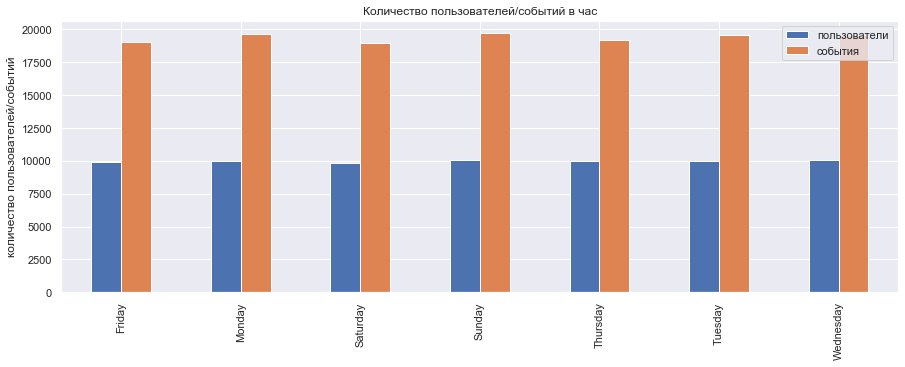

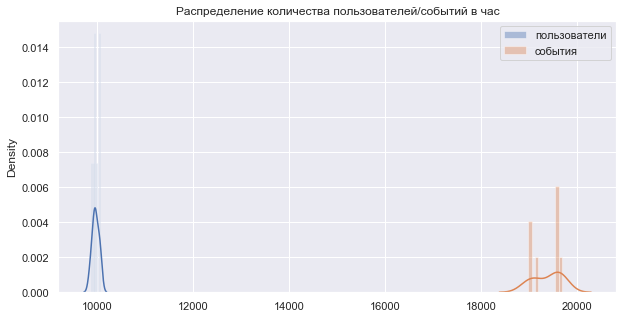

user_count   event_count  events_per_user
count      7.000000      7.000000         7.000000
mean    9973.571429  19377.000000         1.942764
std       68.970663    297.112212         0.019703
min     9868.000000  18979.000000         1.918102
25%     9941.500000  19113.500000         1.925183
50%     9958.000000  19569.000000         1.946798
75%    10022.500000  19591.000000         1.959463
max    10061.000000  19682.000000         1.965154

In [16]:
nusers_period(game_actions, ['weekday'], 'час')

- Зависимость от дня недели на графике не прослеживается. Вероятно, сказывается тот факт, что первая начала игры выпала на выходные дни.

**Посмотрим, как распределено количество участников и событий в зависимости от источника перехода.**

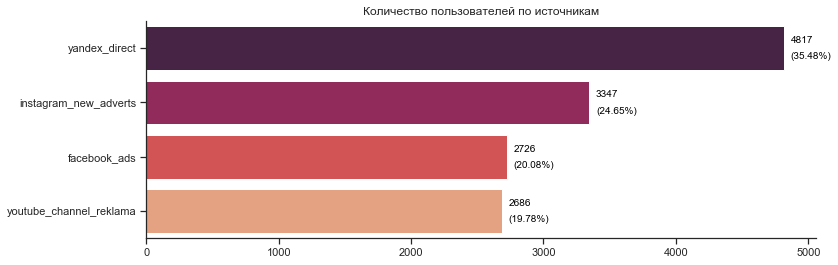

user_count  event_count  events_per_user
source                                                           
yandex_direct                  4817        47694         9.901183
instagram_new_adverts          3347        33757        10.085748
facebook_ads                   2726        27672        10.151137
youtube_channel_reklama        2686        26516         9.871929

In [17]:
rep = game_actions.groupby('source').agg(user_count = ('user_id', 'nunique'), event_count = ('user_id', 'count'))
rep['events_per_user'] = rep['event_count'] / rep['user_count']
rep = rep.sort_values('user_count', ascending=False)

sns.set_style("ticks")
plt.figure(figsize=(12, 4))
plt.title('Количество пользователей по источникам')
sns.barplot(y=rep.index, x=rep['user_count'], palette='rocket', orient='h')

for i, v in enumerate(rep['user_count'].values):
    plt.text(v + 50, i - 0.1, str(v), color='black', fontsize = 10)
    plt.text(v + 50, i + 0.2, '({:.2%})'.format(v / rep['user_count'].sum()), color='black', fontsize = 10)

plt.xlabel('')
plt.ylabel('')
sns.despine()
plt.show()

display(rep)

- Больше всего пользователей пришло из Яндекс.Директ (4817), на втором месте Instagram (3347), далее Facebook (2726) и Youtube (2686).
- Ощутимой разницы в количестве событий на пользователя в зависимости от источника не наблюдается - около 10.

### [3.2. Анализ игровых стратегий пользователей (боевая/строительная - всего и по источнику)](#plan) <a id="st3_2"></a> 

Игроки могут пройти уровень, выполнив одно из условий:
- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

У каждого звершившего уровень игрока встречается событие `game_actions['event'] == 'finished_stage_1'`.
У игроков, прошедших уровень путём Реализации проекта, встречается событие `game_actions['event'] == 'project`, причём, оно не последнее в истории данного пользователя.
Игроки, имеющие событие `finished_stage_1`, но не имеющие `project`, прошли уровень посредством Победы над врагом.

Игроков, прошедших первый уровень путём Разработки орбитальной сборки спутников: 1866
Игроков, прошедших первый уровень путём Победы над первым врагом: 3951
Всего игроков, прошедших первый уровень: 5817 


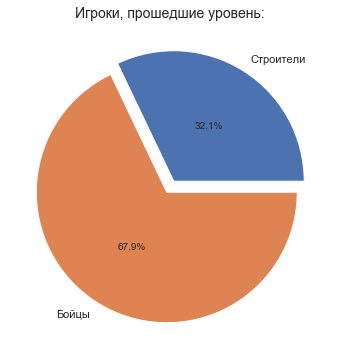

In [18]:
# Всего игроков, прошедших первый уровень:
nfinished = game_actions[game_actions['event'] == 'finished_stage_1']['user_id'].count()
# Игроки, прошедшие уровень за счёт строительства:
nbuilders = game_actions[game_actions['project_type'] == 'satellite_orbital_assembly']['user_id'].count() # совпало с .nunique()
nfighters = nfinished - nbuilders
print('Игроков, прошедших первый уровень путём Разработки орбитальной сборки спутников:', nbuilders)
print('Игроков, прошедших первый уровень путём Победы над первым врагом:', nfinished - nbuilders)
print('Всего игроков, прошедших первый уровень:\033[94m', nfinished, '\033[0m')

success = pd.Series([nbuilders, nfighters], index=['Строители','Бойцы'])

pie, ax = plt.subplots(figsize=[10,6])
labels = success.keys()
plt.pie(x=success, autopct="%.1f%%", explode=[0.05]*2, labels=labels, pctdistance=0.5)
plt.title("Игроки, прошедшие уровень:", fontsize=14);

plt.show()

- Стратегию строительства предпочитают почти в 2 раза реже, чем сражение с врагом.

Добавим в таблицу событий поле с текущим статусом игрока:

In [19]:
# Справочник со списком уникальных событий по каждому пользователю:
EVENTS_BY_USER = game_actions.groupby('user_id')['event'].unique()

In [20]:
def level_status(row):
    """
    Функция вычисляет текущий статус прохождения уровня для события `row`.
    """
    if row['event'] == 'project': # проект завершён
        return 'built_project'
    if row['event'] == "finished_stage_1": # первый уровень завершён
        if 'project' in EVENTS_BY_USER[row['user_id']]: # и была построена орбитальная сборка спутников
            return 'built_project'
        else:                                           # проекта не было
            return 'defeated_first_enemy' 
    else:
        return 'in_process'

In [21]:
game_actions['level_progress'] = game_actions.apply(lambda x: level_status(x), axis=1)

In [22]:
game_actions.sample(5)

event_datetime     event  building_type  \
95070  2020-05-13 01:47:08  building      spaceport   
149    2020-05-04 00:28:53  building  assembly_shop   
1663   2020-05-04 05:14:33  building  assembly_shop   
62163  2020-05-09 22:12:43  building      spaceport   
131064 2020-05-21 01:28:17  building      spaceport   

                                     user_id project_type        date  month  \
95070   12464b3b-8336-468f-96e1-f3783f6e510a          NaN  2020-05-13      5   
149     0d78e032-4a45-48b8-9b9d-0c0cb5177cc1          NaN  2020-05-04      5   
1663    28505c78-cf9e-4921-93d3-d106e6ae523d          NaN  2020-05-04      5   
62163   4894471e-6713-4c9b-8070-32ea87f45277          NaN  2020-05-09      5   
131064  9575b6df-87c7-430d-91de-f70a2acfc483          NaN  2020-05-21      5   

        week    weekday  hour                   source level_progress  
95070     20  Wednesday     1             facebook_ads     in_process  
149       19     Monday     0    instagram_new_adverts     in_process  
1663      19     Monday     5             facebook_ads     in_process  
62163     19   Saturday    22    instagram_new_adverts     in_process  
131064    21   Thursday     1  youtube_channel_reklama     in_process

In [23]:
# Убедимся, что функция сработала правильно:
nbuilders = game_actions[game_actions['level_progress']=='built_project']['user_id'].nunique()
nfighters = game_actions[game_actions['level_progress']=='defeated_first_enemy']['user_id'].nunique()
print('Игроков, прошедших первый уровень путём Разработки орбитальной сборки спутников:', nbuilders)
print('Игроков, прошедших первый уровень путём Победы над первым врагом:', nfighters)
print('Всего игроков, прошедших первый уровень:\033[94m', nfinished, ' = ', nbuilders + nfighters, '\033[0m')

Игроков, прошедших первый уровень путём Разработки орбитальной сборки спутников: 1866
Игроков, прошедших первый уровень путём Победы над первым врагом: 3951
Всего игроков, прошедших первый уровень: 5817  =  5817 


Построим отчёт по пользователям:

In [24]:
user_report = game_actions.groupby(['user_id', 'event'])['user_id'].count().unstack(level=1).reset_index()
# Удалим лишние поля:
user_report = user_report.drop(columns = ['finished_stage_1', 'project'])

# Добавим информацию о количестве построенных объектов каждого типа:
building_count = game_actions.groupby(['user_id', 'building_type'])['user_id'].count().unstack(level=1).reset_index()
user_report = user_report.merge(building_count, how='left', on='user_id')

# Добавим информацию об источнике, из которого пришёл пользователь:
user_report = user_report.merge(user_source, how='left', on='user_id')

#Добавим информацию о первом действии пользователя в игре:
first_event = game_actions.groupby(['user_id']).agg(first_event_datetime = ('event_datetime', 'min')).reset_index()
user_report = user_report.merge(first_event, how='left', on='user_id')

# Добавим информацию о последнем статусе пользователя в игре:
last_progress = game_actions.groupby(['user_id'])['event_datetime'].max().reset_index()
last_progress = last_progress.merge(game_actions, how='left', left_on=['user_id', 'event_datetime'], right_on=['user_id', 'event_datetime'])
# Удалим лишние поля:
last_progress = last_progress.drop(columns = ['event', 'building_type', 'project_type', 'date', 'week', 'hour', 'source'])
last_progress.rename(columns = {'event_datetime':'last_event_datetime', 'level_progress':'last_level_progress'}, inplace = True)
user_report = user_report.merge(last_progress, how='left', on='user_id')

In [25]:
user_report.head()

user_id  building  assembly_shop  \
0  0001f83c-c6ac-4621-b7f0-8a28b283ac30      13.0            6.0   
1  00151b4f-ba38-44a8-a650-d7cf130a0105       9.0            4.0   
2  001aaea6-3d14-43f1-8ca8-7f48820f17aa       4.0            2.0   
3  001d39dc-366c-4021-9604-6a3b9ff01e25       8.0            4.0   
4  002f508f-67b6-479f-814b-b05f00d4e995      12.0            3.0   

   research_center  spaceport                   source first_event_datetime  \
0              1.0        6.0             facebook_ads  2020-05-06 01:07:37   
1              NaN        5.0            yandex_direct  2020-05-06 03:09:12   
2              NaN        2.0  youtube_channel_reklama  2020-05-05 18:08:52   
3              NaN        4.0    instagram_new_adverts  2020-05-05 21:02:05   
4              1.0        8.0             facebook_ads  2020-05-05 13:49:58   

  last_event_datetime  month    weekday   last_level_progress  
0 2020-05-20 11:26:06      5  Wednesday            in_process  
1 2020-05-18 10:46:52      5     Monday            in_process  
2 2020-05-14 09:21:27      5   Thursday            in_process  
3 2020-05-12 07:40:47      5    Tuesday  defeated_first_enemy  
4 2020-05-22 02:46:45      5     Friday            in_process

In [26]:
# Проверим, что статусы в отчёте проставились верно: 
nbuilders = user_report[user_report['last_level_progress']=='built_project']['user_id'].nunique()
nfighters = user_report[user_report['last_level_progress']=='defeated_first_enemy']['user_id'].nunique()
print('Игроков, прошедших первый уровень путём Разработки орбитальной сборки спутников:', nbuilders)
print('Игроков, прошедших первый уровень путём Победы над первым врагом:', nfighters)
print('Всего игроков, прошедших первый уровень:\033[94m', nfinished, ' = ', nbuilders + nfighters, '\033[0m')

Игроков, прошедших первый уровень путём Разработки орбитальной сборки спутников: 1866
Игроков, прошедших первый уровень путём Победы над первым врагом: 3951
Всего игроков, прошедших первый уровень: 5817  =  5817 


**Посмотрим, как распределились стратегии игроков в зависимости от источника**

In [27]:
grp_src_llp = user_report.groupby(['source', 'last_level_progress']).agg(count=('user_id', 'nunique')).reset_index()
grp_temp = grp_src_llp.groupby('source').agg(total=('count', 'sum')).reset_index()
grp_src_llp['total_source'] = grp_src_llp.apply(lambda x: grp_temp[grp_temp['source'] == x.source]['total'].values[0], axis=1)
# Создадим поле с долями стратегий по источнику для отображения на графике:
grp_src_llp['cnt_prc'] = round((grp_src_llp['count'] / grp_src_llp['total_source']) * 100 , 2)
grp_src_llp['cnt_prc'] = grp_src_llp.apply(lambda x: str(x['cnt_prc']) + '%', axis = 1)
grp_src_llp = grp_src_llp.sort_values(by=['total_source', 'count'], ascending=[False, False])

#display(grp_src_llp)

fig = px.bar(grp_src_llp, x='source', y='count', color='last_level_progress',  
             color_discrete_sequence=["#e8505b", "#96bb7c", "#ade498"],
             text = 'cnt_prc')
fig.update_layout(
    title="Результаты игроков по первому уровню в зависимости от источника",
    xaxis_title="",
    yaxis_title="Количество",
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='#f4f4f4'
    #legend_title="Последний статус в игре:"
    )
fig.show()

- Зависимость последнего статуса пользователя от источника не наблюдается. 
- Больше половины всех игроков не прошли уровень, около 30% - выиграли за счёт победы над первым врагом, и около 14% - прошли уровень путём строительства.

**Исследуем время прохождения уровня**

In [28]:
# Добавим в отчёт по пользователям поле с разницей между первым и последним событием в игре:
user_report['game_duration_h'] = (user_report['last_event_datetime'] - user_report['first_event_datetime']).astype('timedelta64[h]')
user_report['game_duration_d'] = (user_report['last_event_datetime'] - user_report['first_event_datetime']).astype('timedelta64[D]')
user_report.sample()

user_id  building  assembly_shop  \
1527  1b7d10bd-9b43-4c85-bb59-62e739159958       6.0            5.0   

      research_center  spaceport                 source first_event_datetime  \
1527              NaN        1.0  instagram_new_adverts  2020-05-05 04:04:36   

     last_event_datetime  month weekday last_level_progress  game_duration_h  \
1527 2020-05-11 21:46:33      5  Monday          in_process            161.0   

      game_duration_d  
1527              6.0

In [29]:
def distribution(df, param, hue, title):
    """
    Функция строит график распределения параметра и выводит его средние значения по заданному разрезу.
    Входные параметры:
        `df` - датафрейм
        `param` - поле датафрейма, по которому нужно построить распределение
        `hue` - поле для фильтрации датафрейма
        `title` - заголовок для графика
    """
    plt.figure(figsize=(10,5))
    plt.title(title)
    for element in df[hue].unique():
        sns.distplot(df[df[hue] == element][param], label = element)
    plt.legend()
    plt.xlabel('')
    plt.show()
    display(df.groupby(hue).agg(param_mean = (param, 'mean'))
                                                    .sort_values('param_mean', ascending=False))

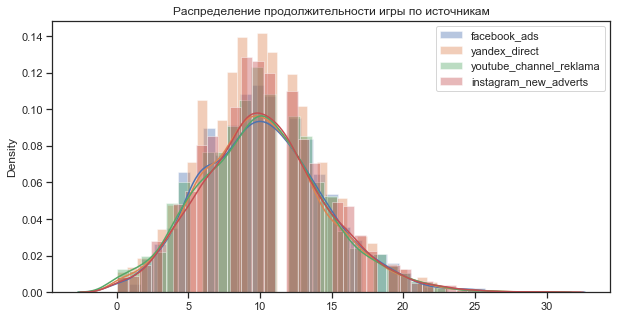

param_mean
source                             
instagram_new_adverts     10.289812
facebook_ads              10.223404
yandex_direct             10.121652
youtube_channel_reklama   10.080045

In [30]:
distribution(user_report, 'game_duration_d', 'source', 'Распределение продолжительности игры по источникам')

- Продолжительность игры практически не зависит от источника, из которого пришёл пользователь.
- Продолжительность распределена нормально.
- Средняя продолжительность игры - **10 дней**

Посмотрим, есть ли зависимость времени прохождения уровня от выбранной пользователем стратегии.

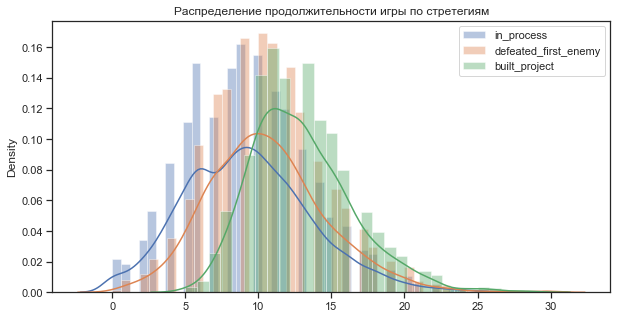

param_mean
last_level_progress             
built_project          12.963023
defeated_first_enemy   10.606176
in_process              9.285475

In [31]:
distribution(user_report, 'game_duration_d', 'last_level_progress', 'Распределение продолжительности игры по стретегиям')

- Распределения продолжительности игры по стратегиям стремятся к нормальному.
- В среднем больше всего времени занимает прохождение уровня путём Разработки орбитальной сборки спутников - 13 дней.
- На втором месте по продолжительности - завершение уровня после Победы над первым врагом - 10-11 дней.
- Игроки, не прошедшие первый уровень, в среднем провели в игре 9 дней.

**Исследуем количество построенных объектов**

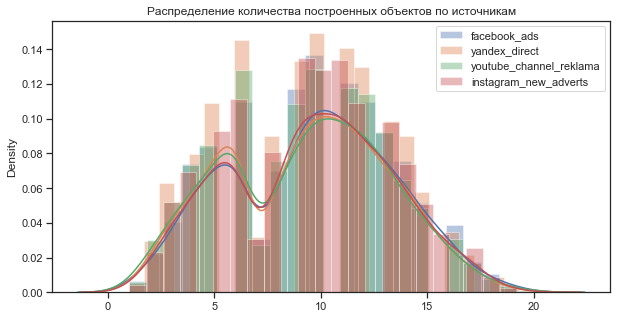

param_mean
source                             
facebook_ads               9.585840
instagram_new_adverts      9.505527
yandex_direct              9.348557
youtube_channel_reklama    9.299330

In [32]:
distribution(user_report, 'building', 'source', 'Распределение количества построенных объектов по источникам')

- Зависимость количества построенных объектов от источника, из которого пришёл пользователь, не прослеживается.
- Отчётливо видно две вершины в распределении - вероятно, сказывается отток после первой недели игры.

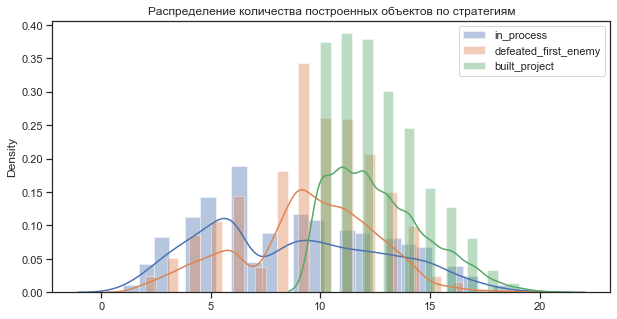

param_mean
last_level_progress             
built_project          12.647910
defeated_first_enemy    9.411541
in_process              8.657043

In [33]:
distribution(user_report, 'building', 'last_level_progress', 'Распределение количества построенных объектов по стратегиям')

- Больше всего объектов в среднем построили пользователи, прошедшие уровень за счёт Разработки орбитальной сборки спутников - 12.6. На втором месте игроки, победившие первого врага - 9.4. Люди, не прошедшие уровень, в среднем построили 8.7 объектов.
- Две вершины имеют распределения количества объектов у пользователей с боевой стратегией и пользователей, так и не прошедших уровень.

**Исследуем частоту постройки объектов разного типа**

Количество построенных объектов в зависимости от источника:

In [34]:
grp_src_building = user_report.groupby('source').agg(spaceport = ('spaceport', 'sum'), 
                                                    assembly_shop = ('assembly_shop', 'sum'), 
                                                    research_center = ('research_center', 'sum')).stack(0).reset_index()
grp_src_building.rename(columns = {'level_1':'building_type', 0:'count'}, inplace = True)
grp_temp = grp_src_building.groupby('source').agg(total=('count', 'sum')).reset_index()
grp_src_building['total_source'] = grp_src_building.apply(lambda x: grp_temp[grp_temp['source'] == x.source]['total'].values[0], axis=1)
grp_src_building['cnt_prc'] = round((grp_src_building['count'] / grp_src_building['total_source']) * 100 , 2)
grp_src_building['cnt_prc'] = grp_src_building.apply(lambda x: str(x['cnt_prc']) + '%', axis = 1)
grp_src_building = grp_src_building.sort_values(by=['total_source','count'], ascending=[False,False])
#display(grp_src_building)

fig = px.bar(grp_src_building, x='source', y='count', color='building_type',  
             color_discrete_sequence=["#522d5b", "#d7385e", "#fb7b6b"],
             text = 'cnt_prc')
fig.update_layout(
    title="Количество построенных объектов разного типа в зависимости от источника",
    xaxis_title="",
    yaxis_title="Количество",
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='#f4f4f4'
    #legend_title="Тип объекта:"
    )
fig.show()

gr_source_building = user_report.groupby('source').agg(total_buildings = ('building', 'sum'),
                                                       spaceport = ('spaceport', 'sum'),
                                                       assembly_shop = ('assembly_shop', 'sum'),
                                                       research_center = ('research_center', 'sum'))
gr_source_building.sort_values('total_buildings', ascending=False, inplace=True)
display(gr_source_building)

total_buildings  spaceport  assembly_shop  \
source                                                               
yandex_direct                    45032.0    20785.0        19295.0   
instagram_new_adverts            31815.0    14847.0        13431.0   
facebook_ads                     26131.0    12069.0        11117.0   
youtube_channel_reklama          24978.0    11624.0        10651.0   

                         research_center  
source                                    
yandex_direct                     4952.0  
instagram_new_adverts             3537.0  
facebook_ads                      2945.0  
youtube_channel_reklama           2703.0

- Зависимость количества построенных объектов того или иного типа от источника пользователя не прослеживается.
- Больше всего было построено `spaceport` (46%), далее `assembly_shop` (43%) и, наконец, `research_center` (11%)

Посмотрим, прослеживается ли зависимость количества построенных объектов разного типа от стратегии, которую выбрал пользователь:

In [35]:
gr_llp_building = user_report.groupby('last_level_progress').agg(spaceport = ('spaceport', 'sum'), 
                                                                 assembly_shop = ('assembly_shop', 'sum'), 
                                                                 research_center = ('research_center', 'sum')).stack(0).reset_index()
gr_llp_building.rename(columns = {'level_1':'building_type', 0:'count'}, inplace = True)
grp_temp = gr_llp_building.groupby('last_level_progress').agg(total=('count', 'sum')).reset_index()
gr_llp_building['total_llp'] = gr_llp_building.apply(lambda x: grp_temp[grp_temp['last_level_progress'] == x.last_level_progress]['total'].values[0], axis=1)
gr_llp_building['cnt_prc'] = round((gr_llp_building['count'] / gr_llp_building['total_llp']) * 100 , 2)
gr_llp_building['cnt_prc'] = gr_llp_building.apply(lambda x: str(x['cnt_prc']) + '%', axis = 1)
gr_llp_building = gr_llp_building.sort_values(by=['total_llp', 'count'], ascending=[False, False])

fig = px.bar(gr_llp_building, x='last_level_progress', y='count', color='building_type',  
             color_discrete_sequence=["#522d5b", "#d7385e", "#fb7b6b"],
             text = 'cnt_prc')

fig.update_layout(
    title="Количество построенных объектов разного типа в зависимости от стратегии пользователя",
    xaxis_title="",
    yaxis_title="Количество",
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='#f4f4f4'
    #legend_title="Тип объекта:"
    )
fig.show()

user_report.groupby('last_level_progress').agg(total = ('building', 'sum'),
                                               spaceport = ('spaceport', 'sum'),
                                               assembly_shop = ('assembly_shop', 'sum'),
                                               research_center = ('research_center', 'sum')
                                              ).sort_values('total', ascending=False)

total  spaceport  assembly_shop  research_center
last_level_progress                                                     
in_process            67170.0    31405.0        29080.0           6685.0
defeated_first_enemy  37185.0    17132.0        16298.0           3755.0
built_project         23601.0    10788.0         9116.0           3697.0

- Пользователи, предпочитающие стратегию строительства, строят больше исследовательских центров (`research_center`) и меньше сборочных цехов (`assembly_shop`), чем другие игроки.

### [3.3. Расчёт метрик (по источнику)](#plan) <a id="st3_3"></a> 

**Частота возвращений пользователя (DAU/WAU/Sticky factor)**

In [36]:
# Подготовим таблицу с метриками по источникам:
source_metrics = pd.DataFrame([
                        ['yandex_direct', None, None, None, None, None, None],
                        ['instagram_new_adverts', None, None, None, None, None, None],
                        ['facebook_ads', None, None, None, None, None, None],
                        ['youtube_channel_reklama', None, None, None, None, None, None],
                       ], columns = ['Источник', 
                                     'Пользователи',
                                     'DAU', 
                                     'WAU', 
                                     'MAU', 
                                     'Sticky factor (week)',
                                     'Sticky factor (month)']).set_index('Источник')

# Заполним поле с количеством привлечённых пользователей:
source_cnt = user_report.groupby('source')['user_id'].nunique()
for src in source_cnt.index:
    source_metrics.loc[source_metrics.index == src, ['Пользователи']] = source_cnt[src]

In [37]:
# Посчитаем и добавим в отчёт метрики посещаемости игры:
for source in game_actions['source'].unique():
    dau_total = game_actions[game_actions['source'] == source].groupby(['date']).agg({'user_id': 'nunique'}).mean()
    wau_total = game_actions[game_actions['source'] == source].groupby(['week']).agg({'user_id': 'nunique'}).mean()
    mau_total = game_actions[game_actions['source'] == source].groupby(['month']).agg({'user_id': 'nunique'}).mean()

    sticky_wau = dau_total / wau_total
    sticky_mau = dau_total / mau_total

    source_metrics.loc[source_metrics.index == source, ['DAU']] = [dau_total]
    source_metrics.loc[source_metrics.index == source, ['WAU']] = [wau_total]
    source_metrics.loc[source_metrics.index == source, ['MAU']] = [mau_total]
    source_metrics.loc[source_metrics.index == source, ['Sticky factor (week)']] = [round(sticky_wau,2)]
    source_metrics.loc[source_metrics.index == source, ['Sticky factor (month)']] = [round(sticky_mau,2)]

source_metrics

Пользователи      DAU     WAU     MAU  \
Источник                                                        
yandex_direct                   4817  1018.73  2161.2  2414.5   
instagram_new_adverts           3347  716.576    1520    1676   
facebook_ads                    2726  585.667  1233.6    1366   
youtube_channel_reklama         2686  581.531  1205.2    1346   

                        Sticky factor (week) Sticky factor (month)  
Источник                                                            
yandex_direct                           0.47                  0.42  
instagram_new_adverts                   0.47                  0.43  
facebook_ads                            0.47                  0.43  
youtube_channel_reklama                 0.48                  0.43

- Если смотреть на относительные показатели (Sticky factor), заметно, что источники практически не отличаются друг от друга по показателям лояльности аудитории.

**Retention rate**

Сформируем когорты по дню первой активности в игре:

In [38]:
# Добавим в таблицу с событиями дату первого действия каждого пользователя:
user_first_event = user_report[['user_id', 'first_event_datetime']].rename(columns = {'first_event_datetime':'first_event_date'})
user_first_event['first_event_date'] = user_first_event['first_event_date'].dt.date

game_actions = game_actions.merge(user_first_event, how='left', on='user_id')

#game_actions.head()      

# Добавим lifetime пользователя в рамках когорты:
game_actions['cohort_lifetime'] = game_actions['date'] - game_actions['first_event_date']
game_actions['cohort_lifetime'] = game_actions['cohort_lifetime'] / np.timedelta64(1,'D')
game_actions['cohort_lifetime'] = round(game_actions['cohort_lifetime']).astype('int')

In [39]:
def cohorts_by_source(source): # source - список источников
    """
    Функция формирует таблицу для когортного анализа по заданному источнику.
    Входной параметр:
        `source` - список с названиями источников
    Выход:
        DataFrame
    """
    cohorts = game_actions[game_actions['source'].isin(source)].groupby(['first_event_date', 'date', 'cohort_lifetime']).agg(
                                                                            count = ('user_id', 'nunique'),
                                                                            buildings = ('building_type', 'count')
                                                                           ).reset_index()
    
    return cohorts

In [40]:
def retention_by_cohorts(cohorts):
    """
    Функция расчитывает Retension rate для каждой когорты и строит по ним тепловую карту.
    Входной параметр:
        `cohorts` - таблица с когортами
    """
    # Найдём исходное количество пользователей в когорте:
    initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_event_date','count']]
    initial_users_count = initial_users_count.rename(columns={'count':'cohort_users'})

    # Объединим данные по когортам с исходным количеством пользователей в когорте:
    cohorts = cohorts.merge(initial_users_count, on='first_event_date')

    # Рассчитаем Retention Rate:
    cohorts['retention'] = cohorts['count'] / cohorts['cohort_users']
    retention_pivot = cohorts.pivot_table(index='first_event_date', columns='cohort_lifetime', values='retention', aggfunc='sum')

    sns.set(style='white')
    plt.figure(figsize=(16, 5))
    plt.title('Коэффициент удержания пользователей по когортам')

    sns.heatmap(retention_pivot.loc[:,1:], annot=True, fmt='.0%', linewidths=1, linecolor='gray', 
                square=True,
                cbar=0
               )
    plt.yticks(rotation=0) 
    plt.xlabel('Lifetime когорты, дни')
    plt.ylabel('Когорты')
    plt.show()

In [41]:
def buildings_by_cohorts(cohorts):
    """
    Функция подсчитывает для каждой когорты количество построенных объектов на пользователя за каждый день жизни (ltv)
    и строит по ним тепловую карту.
    Входной параметр:
        `cohorts` - таблица с когортами
    """
    # Рассчитаем количество построенных объектов на пользователя:
    cohorts['ltv'] = cohorts['buildings'] / cohorts['count']

    output = cohorts.pivot_table(index='first_event_date', 
                                columns='cohort_lifetime', 
                                values='ltv', 
                                aggfunc='mean')

    sns.set(style='white')
    plt.figure(figsize=(16, 5))
    plt.title('Среднее количество построенных объектов на пользователя (накопительное)')
    
    sns.heatmap(output.cumsum(axis=1).round(2), annot=True, linewidths=1, linecolor='gray', 
                square=True,
                cbar=0
               )
    plt.yticks(rotation=0) 
    plt.xlabel('Lifetime когорты, дни')
    plt.ylabel('Когорты')
    plt.show()
    
    # Итоговый LTV по когортам (возьмём только 17 дней, чтобы время жизни всех когорт было одинаковым):
    cohorts[cohorts['cohort_lifetime'] < 18].groupby('first_event_date')['ltv'].sum().plot(figsize=(7,4), grid=True, style='o-', title='Итоговый LTV по когортам')
    print('\033[1mИтоговый LTV по когортам (за 17 дней жизни):')
    display(cohorts[cohorts['cohort_lifetime'] < 18].groupby('first_event_date')['ltv'].sum().reset_index())

Посмотрим на RR по всем источникам в целом:

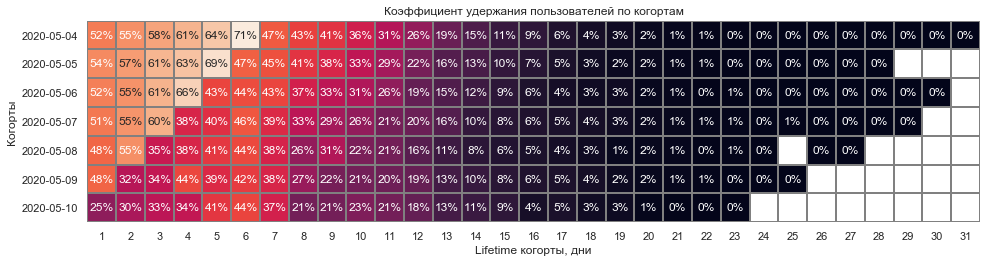

In [42]:
cohorts_total = cohorts_by_source(['youtube_channel_reklama', 'facebook_ads', 'instagram_new_adverts','yandex_direct'])
retention_by_cohorts(cohorts_total)

- Удержание около 50% в первый день - это хороший результат для компьютерной игры.
- В течение недели после запуска наблюдается прирост пользователей в каждой когорте - возможно, хорошо работали напоминания - маркетологам стоит обратить внимание на данный факт. 
- 11.05.2020 случился ощутимый отток, что вполне ожидаемо, т.к. это понедельник. 
- 13.05.2020 наблюдается подъём по трём когортам - возможно, имела место удачная реклама.
- Каждая последующая когорта в целом демонстрирует более скромные результаты, чем предыдущая, и выравниваются они только на 14-15 день игры, где остаётся только десятая часть игроков.

Изучим показатели удержания по источникам:

youtube_channel_reklama:


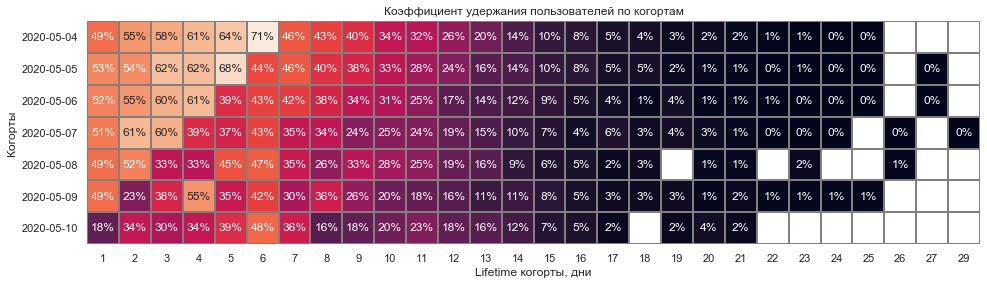

facebook_ads:


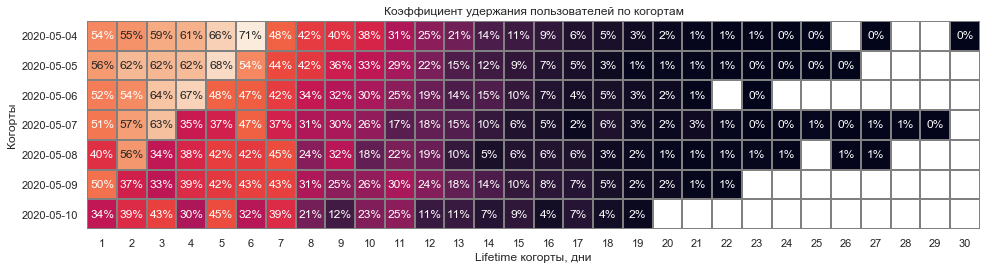

instagram_new_adverts:


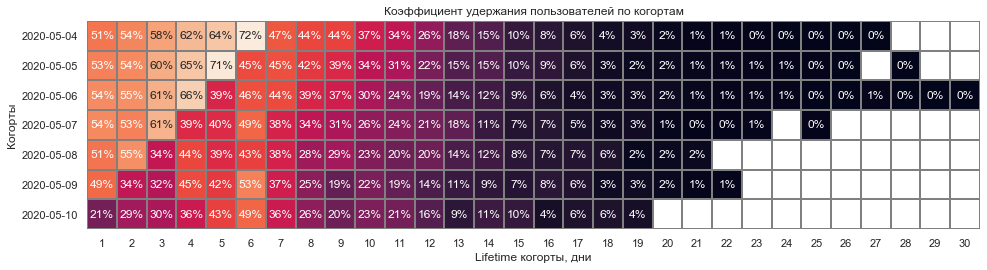

yandex_direct:


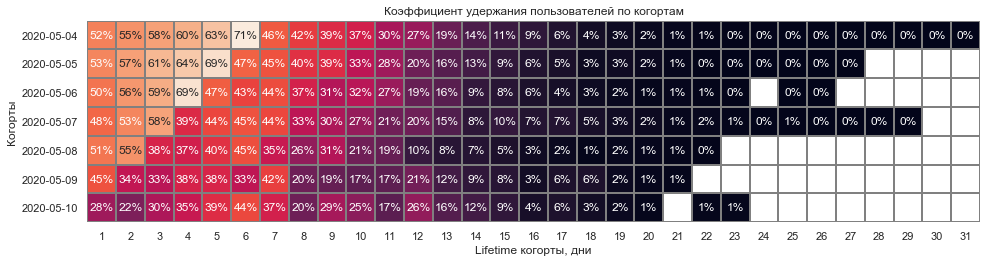

In [43]:
for source in game_actions['source'].unique():
    cohorts_s = cohorts_by_source([source])
    print('\033[94m' + source + ':')
    retention_by_cohorts(cohorts_s)

- В целом, тенденции, отмеченные на общей тепловой карте, прослеживаются и по каждому источнику в отдельности.
- Instagram в целом демонстрирует результаты на пару пунктов выше, чем по остальным источникам.
- Youtube, наоборот, чуть хуже остальных в плане удержания пользователей.

Показатель удержания связан не только с возвращаемостью пользователей, но и с длительностью прохождения уровня. Выше, на гистрограмме с распределением продолжительности игры по источникам, мы установили, что данный показатель от иточника не зависит. 
    
Посмотрим, разнится ли длительность прохождения первого уровня от когорты к когорте:

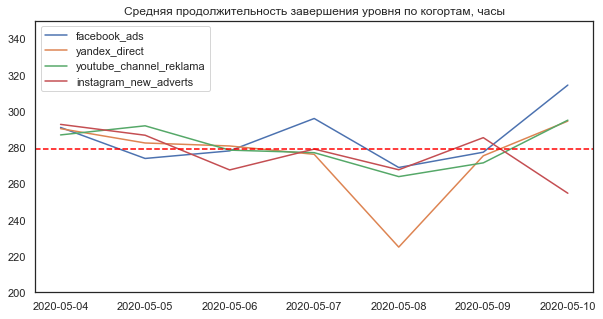

In [44]:
winners = user_report[user_report['last_level_progress'] != 'in_process']['user_id'].unique()

user_report['first_event_date'] = user_report['first_event_datetime'].dt.date
cohorts_win = user_report[user_report['user_id'].isin(winners)].groupby(['first_event_date', 'source']).agg(
                                                                            count = ('user_id', 'nunique'),
                                                                            game_duration = ('game_duration_h', 'mean')).reset_index()


plt.figure(figsize=(10,5))
plt.ylim([200, 350])
plt.title('Средняя продолжительность завершения уровня по когортам, часы')

for source in user_report['source'].unique():
    cohorts_win_s = cohorts_win[cohorts_win['source'] == source]
    plt.plot(cohorts_win_s[['first_event_date', 'game_duration']].set_index('first_event_date'), label=source)

plt.axhline(y = cohorts_win['game_duration'].mean(), color = 'red', linestyle = '--')
plt.xlabel('')
plt.legend()
plt.show()

- Заметное отклонение от среднего наблюдается по Яндекс.Директ в когорте от 8 мая - там пользователи быстрее прошли уровень и это так же могло повлиять на показатели Retention rate, как и факт оттока.

**LTV**

Учитывая, что доход с пользователя планируется получать на экране выбора объекта строительства, примем факт постройки объекта (запись `building_type` в таблице событий) за одну условную единицу выручки. Тогда мы можем рассчитать LTV как количество построенных пользователем объектов.

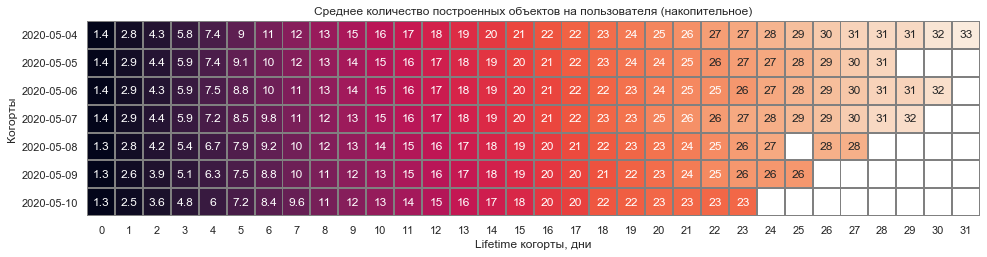

Итоговый LTV по когортам (за 17 дней жизни):


first_event_date        ltv
0       2020-05-04  22.334045
1       2020-05-05  22.020154
2       2020-05-06  21.501836
3       2020-05-07  21.604832
4       2020-05-08  20.921905
5       2020-05-09  20.491476
6       2020-05-10  20.311688

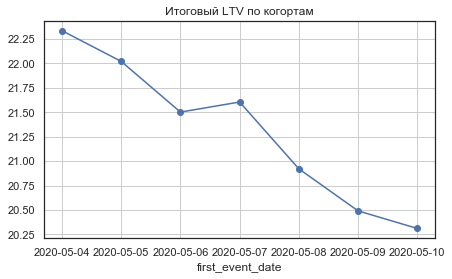

In [45]:
# Посмотрим на LTV по всем источникам в целом:
buildings_by_cohorts(cohorts_total)

- Количества построенных объектов с начала жизни когорты увеличивается день ото дня на 1-2 пункта, и далее, дойдя до 10-13 объектов, увеличивается чётко на 1.
- За первые 17 дней жизни итоговые показатели LTV падают от когорты к когорте. Возможно, играет роль тот факт, что праздничные дни продолжались только до 11 мая и каждая последующая когорта содержала меньше выходных дней.

LTV отдельно по каждому источнику:

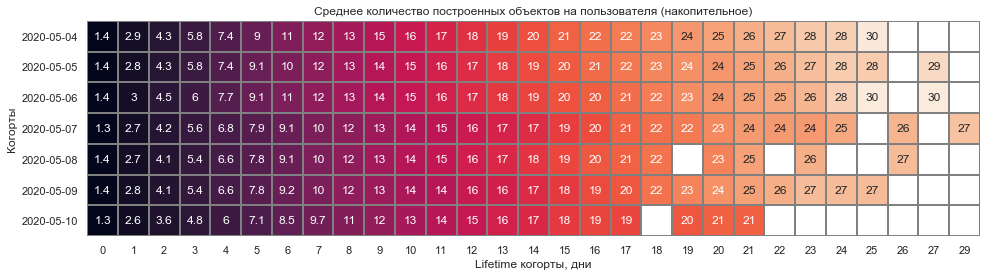

Итоговый LTV по когортам (за 17 дней жизни):


first_event_date        ltv
0       2020-05-04  22.340546
1       2020-05-05  22.080397
2       2020-05-06  21.468894
3       2020-05-07  20.694776
4       2020-05-08  20.786553
5       2020-05-09  20.062776
6       2020-05-10  19.070833

youtube_channel_reklama <---


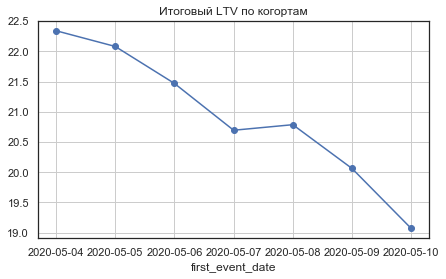

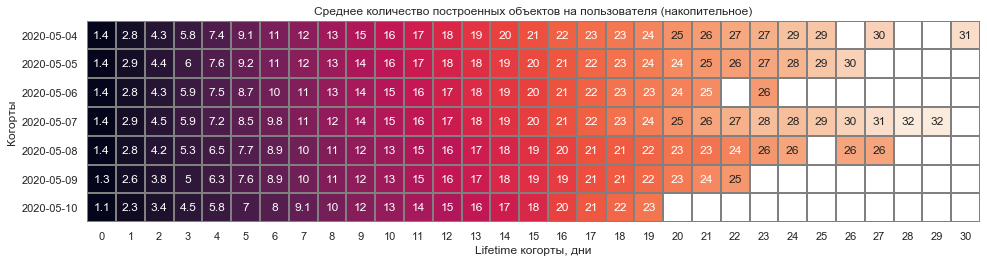

Итоговый LTV по когортам (за 17 дней жизни):


first_event_date        ltv
0       2020-05-04  22.573867
1       2020-05-05  22.088135
2       2020-05-06  21.811819
3       2020-05-07  21.772944
4       2020-05-08  20.829293
5       2020-05-09  20.626898
6       2020-05-10  21.203451

facebook_ads <---


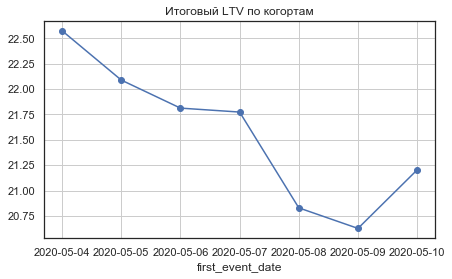

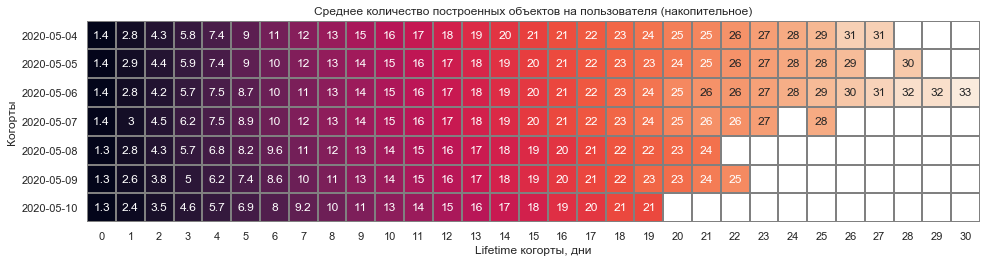

Итоговый LTV по когортам (за 17 дней жизни):


first_event_date        ltv
0       2020-05-04  22.146302
1       2020-05-05  21.939973
2       2020-05-06  22.037333
3       2020-05-07  21.949309
4       2020-05-08  20.785756
5       2020-05-09  20.912910
6       2020-05-10  19.778087

instagram_new_adverts <---


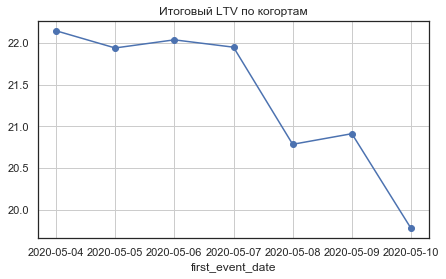

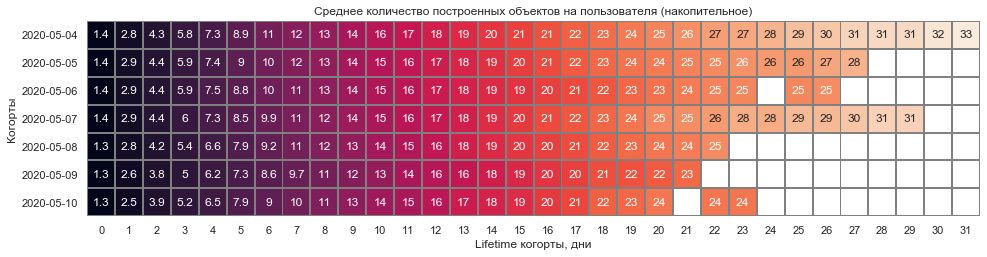

Итоговый LTV по когортам (за 17 дней жизни):


first_event_date        ltv
0       2020-05-04  22.309320
1       2020-05-05  22.001682
2       2020-05-06  20.966668
3       2020-05-07  21.872131
4       2020-05-08  21.118512
5       2020-05-09  20.297008
6       2020-05-10  20.666292

yandex_direct <---


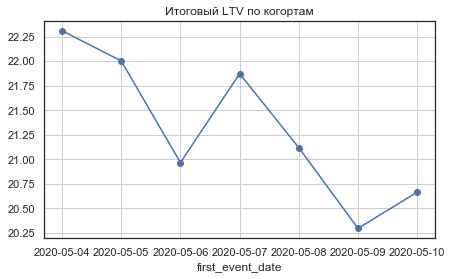

In [46]:
for source in game_actions['source'].unique():
    cohorts_s = cohorts_by_source([source])
    buildings_by_cohorts(cohorts_s)      
    print('\033[94m' + source + ' <---')

- LTV по каждому отдельному источнику выглядит примерно так же, как и по всем источникам вместе - разница между когортами не прослеживается (кроме последней от 10.05.2020, результаты которой почти везде чуть хуже остальных).

**САС (стоимость привлечения пользователя)**

In [47]:
# Посчитаем, сколько пользователей пришли в игру в разрезе источника и дня:
grp_src_users = game_actions.groupby(['source', 'first_event_date']).agg(users = ('user_id', 'nunique')).reset_index()
to_dttime(grp_src_users, 'first_event_date', '%Y-%m-%d')

# Добавим в таблицу с затратами информацию о количестве привлечённых пользователей по дням:
ad_costs = ad_costs.merge(grp_src_users, left_on = ['source', 'date'], right_on = ['source', 'first_event_date'], how='outer').sort_values(by=['source','date'])
ad_costs

source       date        cost first_event_date   users
0              facebook_ads 2020-05-03  935.882786              NaT     NaN
1              facebook_ads 2020-05-04  548.354480       2020-05-04  1184.0
2              facebook_ads 2020-05-05  260.185754       2020-05-05   694.0
3              facebook_ads 2020-05-06  177.982200       2020-05-06   345.0
4              facebook_ads 2020-05-07  111.766796       2020-05-07   224.0
5              facebook_ads 2020-05-08   68.009276       2020-05-08   139.0
6              facebook_ads 2020-05-09   38.723350       2020-05-09    84.0
28             facebook_ads        NaT         NaN       2020-05-10    56.0
7     instagram_new_adverts 2020-05-03  943.204717              NaT     NaN
8     instagram_new_adverts 2020-05-04  502.925451       2020-05-04  1452.0
9     instagram_new_adverts 2020-05-05  313.970984       2020-05-05   796.0
10    instagram_new_adverts 2020-05-06  173.071145       2020-05-06   472.0
11    instagram_new_adverts 2020-05-07  109.915254       2020-05-07   270.0
12    instagram_new_adverts 2020-05-08   71.578739       2020-05-08   175.0
13    instagram_new_adverts 2020-05-09   46.775400       2020-05-09   112.0
29    instagram_new_adverts        NaT         NaN       2020-05-10    70.0
14            yandex_direct 2020-05-03  969.139394              NaT     NaN
15            yandex_direct 2020-05-04  554.651494       2020-05-04  2078.0
16            yandex_direct 2020-05-05  308.232990       2020-05-05  1208.0
17            yandex_direct 2020-05-06  180.917099       2020-05-06   664.0
18            yandex_direct 2020-05-07  114.429338       2020-05-07   395.0
19            yandex_direct 2020-05-08   62.961630       2020-05-08   239.0
20            yandex_direct 2020-05-09   42.779505       2020-05-09   144.0
30            yandex_direct        NaT         NaN       2020-05-10    89.0
21  youtube_channel_reklama 2020-05-03  454.224943              NaT     NaN
22  youtube_channel_reklama 2020-05-04  259.073224       2020-05-04  1146.0
23  youtube_channel_reklama 2020-05-05  147.041741       2020-05-05   663.0
24  youtube_channel_reklama 2020-05-06   88.506074       2020-05-06   366.0
25  youtube_channel_reklama 2020-05-07   55.740645       2020-05-07   220.0
26  youtube_channel_reklama 2020-05-08   40.217907       2020-05-08   135.0
27  youtube_channel_reklama 2020-05-09   23.314669       2020-05-09   100.0
31  youtube_channel_reklama        NaT         NaN       2020-05-10    56.0

- 3 мая игру начали рекламировать по всем каналам, но запуск самой игры состоялся только на следующий день. Поэтому у нас нет данных о количестве привлечённых пользователей за этот день.
- В то же время у нас есть данные о количестве привлечённых пользователей за 10 мая, когда реклама уже не проводилась.
    
В целях расчёта САС сместим значения колонки `users` и `first_event_date` на шаг наверх и удалим строчки с пропусками в `cost`:

In [48]:
ad_costs['users'] = ad_costs['users'].shift(-1)
ad_costs['first_event_date'] = ad_costs['first_event_date'].shift(-1)
ad_costs = ad_costs.dropna(axis='index', how='any', subset=['cost'])
ad_costs

source       date        cost first_event_date   users
0              facebook_ads 2020-05-03  935.882786       2020-05-04  1184.0
1              facebook_ads 2020-05-04  548.354480       2020-05-05   694.0
2              facebook_ads 2020-05-05  260.185754       2020-05-06   345.0
3              facebook_ads 2020-05-06  177.982200       2020-05-07   224.0
4              facebook_ads 2020-05-07  111.766796       2020-05-08   139.0
5              facebook_ads 2020-05-08   68.009276       2020-05-09    84.0
6              facebook_ads 2020-05-09   38.723350       2020-05-10    56.0
7     instagram_new_adverts 2020-05-03  943.204717       2020-05-04  1452.0
8     instagram_new_adverts 2020-05-04  502.925451       2020-05-05   796.0
9     instagram_new_adverts 2020-05-05  313.970984       2020-05-06   472.0
10    instagram_new_adverts 2020-05-06  173.071145       2020-05-07   270.0
11    instagram_new_adverts 2020-05-07  109.915254       2020-05-08   175.0
12    instagram_new_adverts 2020-05-08   71.578739       2020-05-09   112.0
13    instagram_new_adverts 2020-05-09   46.775400       2020-05-10    70.0
14            yandex_direct 2020-05-03  969.139394       2020-05-04  2078.0
15            yandex_direct 2020-05-04  554.651494       2020-05-05  1208.0
16            yandex_direct 2020-05-05  308.232990       2020-05-06   664.0
17            yandex_direct 2020-05-06  180.917099       2020-05-07   395.0
18            yandex_direct 2020-05-07  114.429338       2020-05-08   239.0
19            yandex_direct 2020-05-08   62.961630       2020-05-09   144.0
20            yandex_direct 2020-05-09   42.779505       2020-05-10    89.0
21  youtube_channel_reklama 2020-05-03  454.224943       2020-05-04  1146.0
22  youtube_channel_reklama 2020-05-04  259.073224       2020-05-05   663.0
23  youtube_channel_reklama 2020-05-05  147.041741       2020-05-06   366.0
24  youtube_channel_reklama 2020-05-06   88.506074       2020-05-07   220.0
25  youtube_channel_reklama 2020-05-07   55.740645       2020-05-08   135.0
26  youtube_channel_reklama 2020-05-08   40.217907       2020-05-09   100.0
27  youtube_channel_reklama 2020-05-09   23.314669       2020-05-10    56.0

In [49]:
# Добавим в отчёт стоимость привлечения пользователя в каждый день рекламы:
ad_costs['cac'] = ad_costs['cost'] / ad_costs['users']

# Добавим количество построенных объектов:
grp_src_buildings = game_actions.groupby(['source', 'first_event_date']).agg(buildings = ('building_type', 'count')).reset_index()
to_dttime(grp_src_buildings, 'first_event_date', '%Y-%m-%d')
ad_costs = ad_costs.merge(grp_src_buildings, left_on = ['source', 'first_event_date'], right_on = ['source', 'first_event_date'], how = 'left')

# Рассчитаем LTV по источнику:
ad_costs['ltv'] = ad_costs['buildings'] / ad_costs['users']

ad_costs = ad_costs.drop(columns = ['first_event_date'])
ad_costs = ad_costs[['source' , 'date', 'users', 'buildings', 'cost', 'cac', 'ltv']]
ad_costs

source       date   users  buildings        cost  \
0              facebook_ads 2020-05-03  1184.0      12494  935.882786   
1              facebook_ads 2020-05-04   694.0       6895  548.354480   
2              facebook_ads 2020-05-05   345.0       3087  260.185754   
3              facebook_ads 2020-05-06   224.0       1789  177.982200   
4              facebook_ads 2020-05-07   139.0        949  111.766796   
5              facebook_ads 2020-05-08    84.0        599   68.009276   
6              facebook_ads 2020-05-09    56.0        318   38.723350   
7     instagram_new_adverts 2020-05-03  1452.0      15135  943.204717   
8     instagram_new_adverts 2020-05-04   796.0       7786  502.925451   
9     instagram_new_adverts 2020-05-05   472.0       4221  313.970984   
10    instagram_new_adverts 2020-05-06   270.0       2258  173.071145   
11    instagram_new_adverts 2020-05-07   175.0       1279  109.915254   
12    instagram_new_adverts 2020-05-08   112.0        738   71.578739   
13    instagram_new_adverts 2020-05-09    70.0        398   46.775400   
14            yandex_direct 2020-05-03  2078.0      21233  969.139394   
15            yandex_direct 2020-05-04  1208.0      11664  554.651494   
16            yandex_direct 2020-05-05   664.0       5860  308.232990   
17            yandex_direct 2020-05-06   395.0       3220  180.917099   
18            yandex_direct 2020-05-07   239.0       1642  114.429338   
19            yandex_direct 2020-05-08   144.0        860   62.961630   
20            yandex_direct 2020-05-09    89.0        553   42.779505   
21  youtube_channel_reklama 2020-05-03  1146.0      11773  454.224943   
22  youtube_channel_reklama 2020-05-04   663.0       6402  259.073224   
23  youtube_channel_reklama 2020-05-05   366.0       3218  147.041741   
24  youtube_channel_reklama 2020-05-06   220.0       1637   88.506074   
25  youtube_channel_reklama 2020-05-07   135.0        969   55.740645   
26  youtube_channel_reklama 2020-05-08   100.0        659   40.217907   
27  youtube_channel_reklama 2020-05-09    56.0        320   23.314669   

         cac        ltv  
0   0.790442  10.552365  
1   0.790136   9.935159  
2   0.754162   8.947826  
3   0.794563   7.986607  
4   0.804078   6.827338  
5   0.809634   7.130952  
6   0.691488   5.678571  
7   0.649590  10.423554  
8   0.631816   9.781407  
9   0.665193   8.942797  
10  0.641004   8.362963  
11  0.628087   7.308571  
12  0.639096   6.589286  
13  0.668220   5.685714  
14  0.466381  10.217998  
15  0.459149   9.655629  
16  0.464206   8.825301  
17  0.458018   8.151899  
18  0.478784   6.870293  
19  0.437234   5.972222  
20  0.480669   6.213483  
21  0.396357  10.273124  
22  0.390759   9.656109  
23  0.401753   8.792350  
24  0.402300   7.440909  
25  0.412894   7.177778  
26  0.402179   6.590000  
27  0.416333   5.714286

In [50]:
# Добавим LTV в отчёт по источникам:
source_metrics = source_metrics.join(ad_costs.groupby('source').agg(LTV = ('ltv', 'mean')))

Для расчёта САС в целом по источнику разделим сумму всех рекламных затрат на количество привлечённых пользователей:

In [51]:
# Рассчитаем САС по источникам:
source_cac = ad_costs.groupby('source').agg(cost=('cost', 'sum'), users=('users', 'sum'))
source_cac['CAC'] = source_cac['cost'] / source_cac['users']

# Добавим CAC в отчёт по источникам:
source_metrics = source_metrics.join(source_cac[['CAC']])
source_metrics.sort_values(by='CAC', ascending=False, inplace=True)
source_metrics

Пользователи      DAU     WAU     MAU  \
Источник                                                        
facebook_ads                    2726  585.667  1233.6    1366   
instagram_new_adverts           3347  716.576    1520    1676   
yandex_direct                   4817  1018.73  2161.2  2414.5   
youtube_channel_reklama         2686  581.531  1205.2    1346   

                        Sticky factor (week) Sticky factor (month)       LTV  \
Источник                                                                       
facebook_ads                            0.47                  0.43  8.151260   
instagram_new_adverts                   0.47                  0.43  8.156327   
yandex_direct                           0.47                  0.42  7.986689   
youtube_channel_reklama                 0.48                  0.43  7.949222   

                              CAC  
Источник                           
facebook_ads             0.785365  
instagram_new_adverts    0.645785  
yandex_direct            0.463590  
youtube_channel_reklama  0.397662

Сопоставим затраты на привлечение пользователя и среднее количество объектов на пользователя - по источникам:

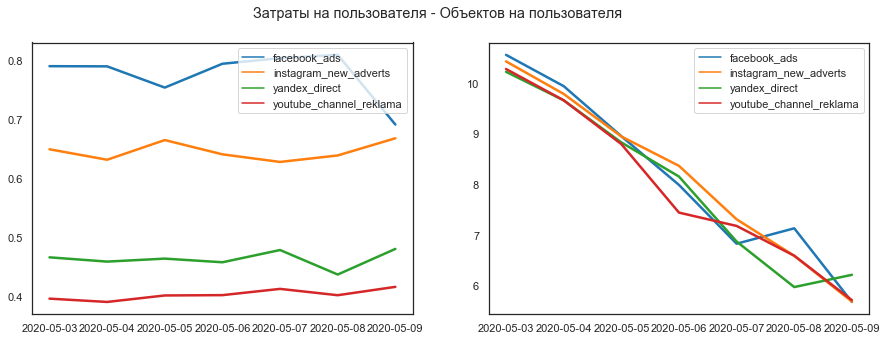

In [52]:
fig, ax = plt.subplots(figsize = (15, 5))
    
sns.lineplot(x='date', y='cac', hue='source', data=ad_costs, palette="tab10", linewidth=2.5, ax=plt.subplot(1, 2, 1))
plt.ylabel('')
plt.xlabel('')
plt.legend()

sns.lineplot(x='date', y='ltv', hue='source', data=ad_costs, palette="tab10", linewidth=2.5, ax=plt.subplot(1, 2, 2))
plt.xlabel('')
plt.ylabel('')
plt.legend()

fig.suptitle('Затраты на пользователя - Объектов на пользователя')
plt.show()

- Дороже всего обходятся пользователи, пришедшие из Facebook'а, далее по убывающей пользователи Instagram и Yandex.Direct. Самая лояльная цена на площадке YouTube.
- Количество построенных объектов (а значит, и количество просмотренных рекламных роликов) практически не зависит от источника трафика.

Итак, нам не удалось установить связь между источником трафика и:
- показателями удержания пользователей
- типами построенных объектов
- длительностью прохождения уровня
- стратегией пользователя и его финальным результатом по уровню (прошёл/не прошёл)

*Зависит ли количество построенных объектов от источника трафика проверим отдельно в разделе [4. Проверка гипотез](#st_4)*
    
Соответственно, нет никакого смысла закупать дорогой трафик. С точки зрения прибыльности нам одинаково интересны как игроки, пришедшие с дорогих Facebook и Instagram, так и пользователи с более выгодых площадок - **YouTube** и **Яндекс.Директ** - именно на этих источниках и стоит масштабировать рекламу.

## [4. Проверка гипотез](#plan) <a id="st4"></a> 

Будем проверять три гипотезы:

- Время завершения уровня различается в зависимости способа прохождения (через реализацию проекта/через победу над первым врагом)
- Количество построенных объектов не зависит от источника трафика
- Количество построенных объектов не зависит от способа прохождения уровня

In [53]:
# Зададим пороговый уровень статистической значимости:
alpha = 0.05

### [4.1. Время завершения уровня различается в зависимости способа прохождения (через реализацию проекта/через победу над первым врагом)](#plan) <a id="st4_1"></a> 

Выделим время прохождения уровня для каждого способа:

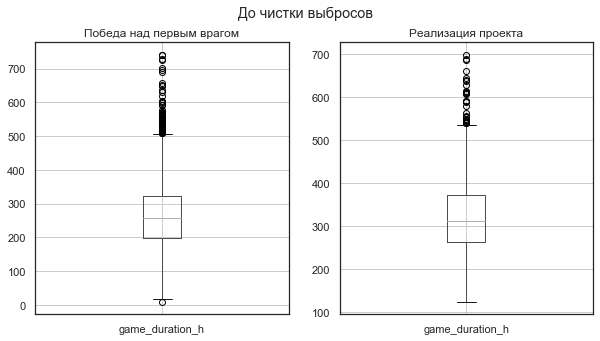

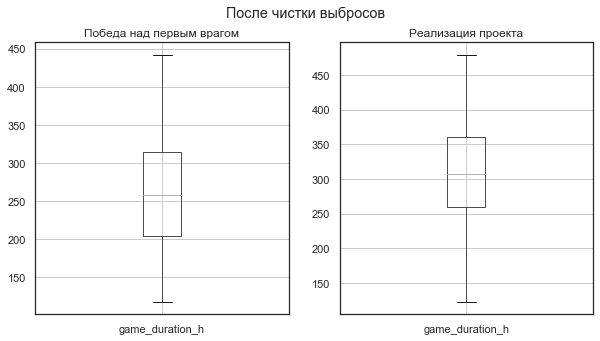

In [54]:
fight_duration = user_report[user_report['last_level_progress'] == 'defeated_first_enemy']['game_duration_h'].reset_index()
project_duration = user_report[user_report['last_level_progress'] == 'built_project']['game_duration_h'].reset_index()

fig, ax = plt.subplots(figsize = (10, 5))

fight_duration.boxplot('game_duration_h', ax = plt.subplot(1, 2, 1))
plt.title('Победа над первым врагом')
project_duration.boxplot('game_duration_h', ax = plt.subplot(1, 2, 2))
plt.title('Реализация проекта')

fig.suptitle('До чистки выбросов')
plt.show()

# Чистим выбросы:
fight_duration = fight_duration[fight_duration['game_duration_h'] < fight_duration['game_duration_h'].quantile(0.95)]
fight_duration = fight_duration[fight_duration['game_duration_h'] > fight_duration['game_duration_h'].quantile(0.05)]
project_duration = project_duration[project_duration['game_duration_h'] < project_duration['game_duration_h'].quantile(0.95)]

fig, ax = plt.subplots(figsize = (10, 5))

fight_duration.boxplot('game_duration_h', ax = plt.subplot(1, 2, 1))
plt.title('Победа над первым врагом')
project_duration.boxplot('game_duration_h', ax = plt.subplot(1, 2, 2))
plt.title('Реализация проекта')

fig.suptitle('После чистки выбросов')
plt.show()

Так как распределения длительности прохождения уровня стремятся к нормальному и не зависимы между собой, для проверки гипотезы мы можем использовать t-критерий Стьюдента:

- H0: медианная длительность прохождения уровня в обеих группах одинаковая
- H1: медианная длительность прохождения уровня в группах 1 и 2 отличается

In [55]:
pvalue = stats.ttest_ind(fight_duration['game_duration_h'].values, project_duration['game_duration_h'].values).pvalue

print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: \033[1mмедианная длительность прохождения уровня в обеих группах одинаковая.\033[0m')
else:
    print('Нулевая гипотеза отвергается: \033[1mмедианная длительность прохождения уровня в группах А и В отличается.\033[0m')
    print(fight_duration['game_duration_h'].median(), project_duration['game_duration_h'].median())


p-value: 4.390727396900911e-111
Нулевая гипотеза отвергается: медианная длительность прохождения уровня в группах А и В отличается.
258.0 307.0


- Пользователи, выбравшие стратегию строительства, в среднем проходят уровень дольше.

### [4.2. Количество построенных объектов не зависит от источника трафика](#plan) <a id="st4_2"></a> 

Подготовим массивы с количеством построенных объектов для каждого источника:

In [56]:
facebook = user_report[user_report['source'] == 'facebook_ads']['building'].values
yandex_direct = user_report[user_report['source'] == 'yandex_direct']['building'].values
youtube = user_report[user_report['source'] == 'youtube_channel_reklama']['building'].values
instagram = user_report[user_report['source'] == 'instagram_new_adverts']['building'].values

Так как распределения количества объектов по источникам отличаются от нормального и не зависят между собой, для проверки гипотезы воспользуемся критерием Краскелла-Уоллиса (многомерное обобщение критерия Уилкоксона-Манна-Уитни):

- H0: среднее количество построенных объектов не зависит от источника трафика
- H1: среднее количество построенных объектов зависит от источника трафика

In [57]:
pvalue = stats.kruskal(facebook, yandex_direct, youtube, instagram).pvalue

print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: \033[1mсреднее количество построенных объектов не зависит от источника трафика.\033[0m')
else:
    print('Нулевая гипотеза отвергается: \033[1mсреднее количество построенных объектов по источникам отличается.\033[0m')
    print(facebook.mean(), yandex_direct.mean(), youtube.mean(), instagram.mean())

p-value: 0.023562546555828536
Нулевая гипотеза отвергается: среднее количество построенных объектов по источникам отличается.
9.585840058694057 9.348557193273821 9.299329858525688 9.50552733791455


- Мы получили статистически значимую разницу при сравнии среднего количества построенных объектов по источникам. Выясним подробнее, какие именно источники различаются:
    
Поскольку тестов у нас 6 (попарное сравнение 4 источников), проведём коррекцию уровня значимости методом Бонферрони:

In [58]:
alpha_b = alpha / 6

In [59]:
pvalue = stats.mannwhitneyu(yandex_direct, facebook)[1]

print('p-value: {}'.format(pvalue))
if pvalue >= alpha_b: 
    print('Нулевая гипотеза не отвергается: \033[1mсреднее количество построенных объектов одинаково для обоих источников.\033[0m')
else:
    print('Нулевая гипотеза отвергается: \033[1mсреднее количество построенных объектов различается по источникам.\033[0m')
    print(facebook.mean(), yandex_direct.mean())

p-value: 0.007191819162027336
Нулевая гипотеза отвергается: среднее количество построенных объектов различается по источникам.
9.585840058694057 9.348557193273821


In [60]:
pvalue = stats.mannwhitneyu(yandex_direct, youtube)[1]

print('p-value: {}'.format(pvalue))
if pvalue >= alpha_b: 
    print('Нулевая гипотеза не отвергается: \033[1mсреднее количество построенных объектов одинаково для обоих источников.\033[0m')
else:
    print('Нулевая гипотеза отвергается: \033[1mсреднее количество построенных объектов различается по источникам.\033[0m')
    print(yandex_direct.mean(), youtube.mean())

p-value: 0.32570773947946574
Нулевая гипотеза не отвергается: среднее количество построенных объектов одинаково для обоих источников.


In [61]:
pvalue = stats.mannwhitneyu(yandex_direct, instagram)[1]

print('p-value: {}'.format(pvalue))
if pvalue >= alpha_b: 
    print('Нулевая гипотеза не отвергается: \033[1mсреднее количество построенных объектов одинаково для обоих источников.\033[0m')
else:
    print('Нулевая гипотеза отвергается: \033[1mсреднее количество построенных объектов различается по источникам.\033[0m')
    print(yandex_direct.mean(), instagram.mean())

p-value: 0.05094467863328855
Нулевая гипотеза не отвергается: среднее количество построенных объектов одинаково для обоих источников.


In [62]:
pvalue = stats.mannwhitneyu(facebook, youtube)[1]

print('p-value: {}'.format(pvalue))
if pvalue >= alpha_b: 
    print('Нулевая гипотеза не отвергается: \033[1mсреднее количество построенных объектов одинаково для обоих источников.\033[0m')
else:
    print('Нулевая гипотеза отвергается: \033[1mсреднее количество построенных объектов различается по источникам.\033[0m')
    print(facebook.mean(), youtube.mean())

p-value: 0.005394178173558069
Нулевая гипотеза отвергается: среднее количество построенных объектов различается по источникам.
9.585840058694057 9.299329858525688


In [63]:
pvalue = stats.mannwhitneyu(facebook, instagram)[1]

print('p-value: {}'.format(pvalue))
if pvalue >= alpha_b: 
    print('Нулевая гипотеза не отвергается: \033[1mсреднее количество построенных объектов одинаково для обоих источников.\033[0m')
else:
    print('Нулевая гипотеза отвергается: \033[1mсреднее количество построенных объектов различается по источникам.\033[0m')
    print(facebook.mean(), instagram.mean())

p-value: 0.19358183653421618
Нулевая гипотеза не отвергается: среднее количество построенных объектов одинаково для обоих источников.


In [64]:
pvalue = stats.mannwhitneyu(youtube, instagram)[1]

print('p-value: {}'.format(pvalue))
if pvalue >= alpha_b: 
    print('Нулевая гипотеза не отвергается: \033[1mсреднее количество построенных объектов одинаково для обоих источников.\033[0m')
else:
    print('Нулевая гипотеза отвергается: \033[1mсреднее количество построенных объектов различается по источникам.\033[0m')
    print(youtube.mean(), instagram.mean())

p-value: 0.03300228241677472
Нулевая гипотеза не отвергается: среднее количество построенных объектов одинаково для обоих источников.


Статистически значимая разница обнаружена для следующих пар источнков:
- Facebook - Yandex.Директ (9.59 против 9.35)
- Facebook - YouTube (9.59 против 9.30)
    
Данную разницу стоит учесть при выборе той или иной площадки для размещения рекламы.

### [4.3. Количество построенных объектов не зависит от способа прохождения уровня](#plan) <a id="st4_3"></a> 

Подготовим массивы с количеством построенных объектов для каждого способа:

In [65]:
fight_building = user_report[user_report['last_level_progress'] == 'defeated_first_enemy']['building'].values
project_building = user_report[user_report['last_level_progress'] == 'built_project']['building'].values

Так как распределения количества объектов для разных способов прохождения уровня отличаются от нормального и их всего два, для проверки гипотезы мы можем использовать критерий Манна-Уиттни:

- H0: среднее количество построенных объектов одинаково для обоих способов прохождения уровня
- H1: среднее количество построенных объектов различается по способам прохождения уровня

In [66]:
pvalue = stats.mannwhitneyu(fight_building, project_building)[1]

print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: \033[1mсреднее количество построенных объектов одинаково для обоих способов прохождения уровня.\033[0m')
else:
    print('Нулевая гипотеза отвергается: \033[1mсреднее количество построенных объектов различается по способам прохождения уровня.\033[0m')
    print(round(fight_building.mean(), 2), round(project_building.mean(), 2))

p-value: 2.605963137511153e-305
Нулевая гипотеза отвергается: среднее количество построенных объектов различается по способам прохождения уровня.
9.41 12.65


- Пользователи, предпочитающие проходить уровень путём разработки орбитальной сборки спутников, в среднем строят больше объектов, чем те, кто проходит уровень за счёт победы над врагом.

## [5. Выводы и рекомендации](#plan) <a id="st5"></a> 

В ходе **анализа посещаемости** компьютерной игры были установлены следующие факты:
- Среднее количество уникальных пользователей в день: 2885
- Среднее количество событий в день: 4110
- Среднее количество событий на пользователя: 1.33
- По времени суток количество пользователей и событий распределено довольно равномерно - вероятно, игроки рассредоточены по разным часовым поясам.
- Наибольшую активность пользователи в целом проявляют в первую неделю игры, после чего наблюдается ощутимый отток - вероятно, по причине окончания майских праздников.

**Анализ игровых стратегий**:
- Больше половины всех игроков не прошли уровень до конца, около 30% - выиграли за счёт победы над первым врагом, и около 14% - прошли уровень путём строительства.
- В среднем больше всего времени занимает прохождение уровня путём Разработки орбитальной сборки спутников - 13 дней. На втором месте по продолжительности - завершение уровня после Победы над первым врагом - 10-11 дней. Игроки, не прошедшие первый уровень, в среднем провели в игре 9 дней.
- Зависимость итоговой стратегии пользователя от источника не наблюдается. 

**Продолжительность игры**:
- Средняя продолжительность игры - **10 дней**
- Продолжительность игры практически не зависит от источника, из которого пришёл пользователь.

**Количество построенных объектов**:
- Больше всего объектов в среднем построили пользователи, прошедшие уровень за счёт Разработки орбитальной сборки спутников - 12.6. На втором месте игроки, победившие первого врага - 9.4. Люди, не прошедшие уровень, в среднем построили 8.7 объектов.
- Разница в количестве построенных объектов обнаружена только для следующих пар источников:
    - Facebook - Yandex.Директ (9.59 против 9.35)
    - Facebook - YouTube (9.59 против 9.30)
- Больше всего было построено `spaceport` (46%), далее `assembly_shop` (43%) и, наконец, `research_center` (11%)
- Распределение типов построенных объектов не зависит от конечной стратегии пользователя.

In [67]:
source_metrics

Пользователи      DAU     WAU     MAU  \
Источник                                                        
facebook_ads                    2726  585.667  1233.6    1366   
instagram_new_adverts           3347  716.576    1520    1676   
yandex_direct                   4817  1018.73  2161.2  2414.5   
youtube_channel_reklama         2686  581.531  1205.2    1346   

                        Sticky factor (week) Sticky factor (month)       LTV  \
Источник                                                                       
facebook_ads                            0.47                  0.43  8.151260   
instagram_new_adverts                   0.47                  0.43  8.156327   
yandex_direct                           0.47                  0.42  7.986689   
youtube_channel_reklama                 0.48                  0.43  7.949222   

                              CAC  
Источник                           
facebook_ads             0.785365  
instagram_new_adverts    0.645785  
yandex_direct            0.463590  
youtube_channel_reklama  0.397662

**Анализ метрик по источнику**:
- Больше всего пользователей пришло из Яндекс.Директ (4817), на втором месте Instagram (3347), далее Facebook (2726) и Youtube (2686).
- Ощутимой разницы в количестве событий на пользователя в зависимости от источника не наблюдается - около 10.
- Показатели лояльности аудитории (Sticky factor) по источникам практически не отличаются.
- Показатели удержания пользователей Retention rate не отличаются по источникам.
- Средние LTV по источникам также практически не отличаются.
- Дороже всего обходятся пользователи, пришедшие из Facebook'а, далее по убывающей пользователи Instagram и Yandex.Direct. Самая лояльная цена на площадке YouTube.
- Количество построеннных объектов (а значит, и количество просмотренных рекламных роликов) различается только для следующих пар источников:
    - Facebook - Yandex.Директ (9.59 против 9.35)
    - Facebook - YouTube (9.59 против 9.30).

**Результаты проверки гипотез**:
- Медианная длительность прохождения уровня отличается в зависимости от стратегии прохождения уровня.
Пользователи, выбравшие стратегию строительства, в среднем проходят уровень дольше.
- Среднее количество построенных объектов различается только для следующих пар источников:
    - Facebook - Yandex.Директ (9.59 против 9.35)
    - Facebook - YouTube (9.59 против 9.30).
- Среднее количество построенных объектов различается по способам прохождения уровня.
Пользователи, предпочитающие проходить уровень путём разработки орбитальной сборки спутников, в среднем строят больше объектов, чем те, кто проходит уровень за счёт победы над врагом.

### Рекомендации

Таким образом, в ходе анализа нам не удалось установить связь между источником трафика и:
- показателями удержания пользователей;
- типами построенных объектов;
- длительностью прохождения уровня;
- стратегией пользователя и его финальным результатом по уровню (прошёл/не прошёл).

Разница в количестве построенных объектов обнаружена только для следующих пар источников: 
- Facebook - Yandex.Директ (9.59 против 9.35)
- Facebook - YouTube (9.59 против 9.30)</font>
    
Учитывая, что САС по данным источникам различается контрастнее, чем количество построенных объектов, закупать дорогой трафик смысла нет. С точки зрения прибыльности нам одинаково интересны как игроки пришедшие с дорогих Facebook и Instagram, так и пользователи из более выгодных площадок - **YouTube** и **Яндекс.Директ** - именно на этих площадках и стоит масштабировать рекламу.

Также, согласно текущей модели монетизации сервиса, выручка с клиента зависит от количества построенных им объектов. Значит, нам выгоднее пользователи, предпочитающие стратегию строительства, а не сражение с врагом. Возможно, стоит сбалансировать игровые стратегии, выровняв время прохождения уровня, чтобы сделать строительство более привлекательным для игроков.